In [334]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from collections import defaultdict

os.chdir("../NewsAppData/")

In [335]:
df1 = pd.read_csv("logs/tcpdump_9.49.14.log", sep="|")
#df2 = pd.read_csv("logs/tcpdump_22.59.47.log", sep="|")
#df3 = pd.read_csv("logs/tcpdump_23.40.32.log", sep="|")

In [336]:
df1.columns

Index(['frame.number', 'frame.time', 'frame.time_relative', 'frame.len',
       'ip.version', 'ip.proto', 'ip.src', 'ip.dst', 'ip.flags',
       'ip.frag_offset', 'ip.ttl', 'ip.len', 'ip.fragment.error', 'tcp.stream',
       'tcp.time_relative', 'tcp.time_delta', 'tcp.srcport', 'tcp.dstport',
       'tcp.len', 'tcp.hdr_len', 'tcp.pdu.size', 'tcp.window_size',
       'tcp.flags', 'tcp.flags.fin', 'tcp.flags.ack', 'tcp.flags.syn',
       'tcp.analysis.retransmission', 'tcp.analysis.rto',
       'tcp.analysis.ack_rtt', 'tcp.analysis.initial_rtt',
       'tcp.analysis.bytes_in_flight', 'tcp.analysis.duplicate_ack',
       'tcp.analysis.fast_retransmission', 'tcp.analysis.flags',
       'tcp.analysis.keep_alive', 'tcp.analysis.keep_alive_ack',
       'tcp.analysis.lost_segment', 'tcp.analysis.out_of_order',
       'tcp.analysis.reused_ports', 'tcp.analysis.rto_frame',
       'tcp.analysis.spurious_retransmission', 'tcp.analysis.tfo_syn',
       'tcp.analysis.window_full', 'tcp.analysis.wind

In [337]:
other_col_names = [
    'frame.number', 'ip.version', 'ip.proto', 'ip.src', 'ip.dst', 'ip.flags'
]

tcp_col_names = [ 'frame.time', 'frame.time_relative',
    'tcp.stream', 'tcp.srcport', 'tcp.dstport', 'tcp.flags', 'tcp.time_relative',
    'tls.record.content_type', 'tls.handshake.type', 'tls.alert_message',
    'tls.handshake.cert_type.type', 'tls.handshake.extensions_server_name',
    'tls.handshake.extensions_alpn_str',
    'http.response.code', 'http.request.full_uri', 'http.request.uri', 'http.time'
]

udp_col_names = [ 'frame.time', 'frame.time_relative',
    'udp.stream', 'udp.dstport', 'udp.srcport',
    'dns.flags', 'dns.time', 'dns.count.queries', 'dns.qry.name', 'dns.resp.ttl'
]

# Waterfall

In [338]:
df = df1.copy()

# frame.time is used to merge dns and tcp data over server name for similar timings
df["frame.time"] = pd.to_datetime(df["frame.time"])

## UDP/DNS TIMINGS

### DNS Lookup/Response Time
- groupby(dns.qry.name)
- server => avg(dns.time)

In [339]:
df_dns = df[ ~df["dns.time"].isnull() ][udp_col_names]

In [340]:
df_dns.head()

,frame.time,frame.time_relative,udp.stream,udp.dstport,udp.srcport,dns.flags,dns.time,dns.count.queries,dns.qry.name,dns.resp.ttl
47,2019-12-23 04:19:36.815810,18.656714,0.0,38653.0,53.0,0x00008180,0.049321,1.0,graph.facebook.com,"2232,2232,52"
54,2019-12-23 04:19:36.906842,18.747746,1.0,43817.0,53.0,0x00008180,0.039141,1.0,sdk.iad-01.braze.com,"121,24"
95,2019-12-23 04:19:37.321017,19.161921,2.0,49650.0,53.0,0x00008180,0.267539,1.0,api.branch.io,31
157,2019-12-23 04:19:38.257408,20.098312,3.0,48210.0,53.0,0x00008180,0.039904,1.0,cdn.branch.io,"58,58,58,58"
169,2019-12-23 04:19:38.372723,20.213627,4.0,44242.0,53.0,0x00008180,0.070952,1.0,appfeeds.intoday.in,"300,1955,7"


In [341]:
df_dns.groupby(["dns.qry.name"])["frame.time_relative"].count()

dns.qry.name
adx.g.doubleclick.net                   1
akm-img-a-in.tosshub.com               14
alt2-mtalk.google.com                   2
api.branch.io                           2
api.openweathermap.org                  1
appfeeds.intoday.in                     3
b.scorecardresearch.com                 3
c.ndtvimg.com                           2
cdn.branch.io                           1
cdn.liftoff.io                          1
connectivitycheck.gstatic.com           4
electionresults.intoday.in             26
feeds.intoday.in                        1
firebaseremoteconfig.googleapis.com     1
fonts.googleapis.com                    1
fonts.gstatic.com                       1
geomobileservices-pa.googleapis.com     1
googleads.g.doubleclick.net             1
googleads4.g.doubleclick.net            3
graph.facebook.com                      1
i1.ytimg.com                            1
impression-asia.liftoff.io              1
indiatoday-pdelivery.akamaized.net      1
lh3.googleusercontent

In [342]:
df_dns_time = df_dns[["dns.qry.name", "frame.time_relative", "frame.time", "dns.time"]].copy()
df_dns_time["t_dns_start"] = df_dns_time["frame.time_relative"] - df_dns_time["dns.time"]
df_dns_time.rename(columns={"frame.time_relative":"t_dns_end",
                            "dns.time": "dns_query_time",
                            "dns.qry.name": "server"}, inplace=True)

df_dns_time.head()

,server,t_dns_end,frame.time,dns_query_time,t_dns_start
47,graph.facebook.com,18.656714,2019-12-23 04:19:36.815810,0.049321,18.607393
54,sdk.iad-01.braze.com,18.747746,2019-12-23 04:19:36.906842,0.039141,18.708605
95,api.branch.io,19.161921,2019-12-23 04:19:37.321017,0.267539,18.894382
157,cdn.branch.io,20.098312,2019-12-23 04:19:38.257408,0.039904,20.058408
169,appfeeds.intoday.in,20.213627,2019-12-23 04:19:38.372723,0.070952,20.142675


## TCP/TLS/DATA TIMINGS
- groupby(tcp.stream)
- set column df['server'] = 'tls.handshake.extensions_server_name'

### TCP HANDSHAKE

- TCP Handshake: start of TCP stream to start of first TLS packet at client device (dst port == 443)
    - First TLS packet is a CLIENT HELLO: tls.record.content_type == 22 and tls.handshake.type == 1
    
### TLS HANDSHAKE
- TLS Handshake: start of TLS packet to start of first DATA packet
    - First DATA packet is TLS with CONTENT TYPE DATA: tls.record.content_type == 22
    - if no TLS packets with CLIENT HELLO or no TLS packets at all (ie. no tls.handshake.type == 1 packets):
        1. Either only TCP no TLS throughout (maybe HTTP was used or no data was sent, just signalling)
        2. Or only a few TLS packets on Encrypted Alert type (tls.record.content_type ==21). These are used by a sender to signal that an open TLS stream should be closed and should not be counted as part of data download times.
        
### DATA TIME
- DATA time: First DATA packet to last DATA packet (in TLS)
    - Time between all packets for which tls.record.content_type == 23
    - Time for the first data packet is Time To First Byte (TTFB) for that tcp stream.
    - There shouldn't really be other type packets in the middle of a continuous DATA stream, unless the cipher suit is getting reused on the same stream and an encrypted alert was not used to close it. If we do see such discrete blocks of DATA downloads, we should count DATA time until the last DATA packet
    - TODO: In above case, it may be better to separately mark the time in the middle of two discrete DATA downloads on the same connection as an EMPTY PERIOD if it was of any considerable length (like a few seconds). In this case the TCP/TLS connection was open but no data packet was being sent in the middle so it shouldn't really count towards calculating data rates, but for the purpose of analysis it cannot be neglected in the waterfall since there is data following a time gap.
    
- In case of no TLS, DATA would be plain HTTP. But this is a very rare case in our traces.
    - For now, use the first http.time to find TTFB and the last http.time to find the DATA download.
    - TODO: this probably can be improved based on pcap2har code if needed for traces that don't use TLS.
    

In [343]:
df_tcp = df[ ~df["tcp.time_relative"].isnull()][tcp_col_names]

gp_tcp = df_tcp.groupby("tcp.stream")

In [344]:
tcp_dict = defaultdict(list)

for stream, row in gp_tcp:
    
    stream_time = row.iloc[0]["frame.time"]
    t_tcp_start, t_tls_start, tls_esni, tls_data_proto, t_data_ttfb, t_data_end = np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
    
    # TCP handshake time start; assume first frame in stream is start of stream
    t_tcp_start = row.iloc[0]["frame.time_relative"]
    
    if len(row.loc[row["tls.handshake.type"]=="1"])>0:
        # if TLS, TCP handshake time ends when first TLS packet is generated
        # if multiple HELLOs, we end up using the first one, but this shouldn't really happen in a single tcp.stream
        
        # first CLIENT HELLO packet should contain server name and protocol
        tls_client_hello_packet = row.loc[row["tls.handshake.type"]=="1"].iloc[0]
        t_tls_start = tls_client_hello_packet["frame.time_relative"]
        
        # Extract the server name and the DATA protocol (usually http/1.1) from TLS CLIENT HELLO PACKET
        tls_esni = tls_client_hello_packet["tls.handshake.extensions_server_name"]
        tls_data_proto = tls_client_hello_packet["tls.handshake.extensions_alpn_str"]
        
        if len(row.loc[row["tls.record.content_type"]=="23"])>0:
            # if TLS has actual DATA, find the time taken for the complete DATA block
            # TODO: Special Case of multiple DATA blocks in the same stream with large gaps in the middle.
            data_block = row.loc[row["tls.record.content_type"]=="23"]
            t_data_ttfb = data_block.iloc[0]["frame.time_relative"]
            t_data_end = data_block.iloc[-1]["frame.time_relative"]
            
            num_pkts = len(row.iloc[data_block.index[0]:data_block.index[-1]])
            if len(data_block) < num_pkts:
                print("Number of extra packets in stream %d: (%d - %d) = %d" %(stream, num_pkts, len(data_block), num_pkts-len(data_block)))
                
        else:
            pass
    
    else: 
        # should be only TCP (maybe with a TLS Encrypted Alert to end the connection)
        if len(row[~row["http.response.code"].isnull()])>0:
            # check for HTTP
            t_data_ttfb = row[~row["http.response.code"].isnull()].iloc[0]["frame.time_relative"]
            t_data_end = row[~row["http.response.code"].isnull()].iloc[-1]["frame.time_relative"]
        else:
            # if no HTTP but there was only TCP signalling with no real data => don't count in waterfall
            # there may be a TLS encrypted alert - should not count in waterfall
            pass
    
    # update with values or nan as needed
    tcp_dict["frame.time"].append(stream_time)
    
    tcp_dict["tcp.stream"].append(stream)
    tcp_dict["server"].append(tls_esni)
    tcp_dict["tls_data_proto"].append(tls_data_proto)
    
    tcp_dict["t_tcp_start"].append(t_tcp_start)
    tcp_dict["t_tls_start"].append(t_tls_start)
    tcp_dict["tcp_handshake_time"].append(t_tls_start-t_tcp_start)
    tcp_dict["t_data_ttfb"].append(t_data_ttfb)
    tcp_dict["tls_handshake_time"].append(t_data_ttfb-t_tls_start)
    tcp_dict["t_data_end"].append(t_data_end)
    tcp_dict["data_download_time"].append(t_data_end-t_data_ttfb)
    

Number of extra packets in stream 0: (6 - 3) = 3
Number of extra packets in stream 12: (1181 - 573) = 608


In [345]:
df_tcp_time = pd.DataFrame(tcp_dict)

df_tcp_time.head(10)

,frame.time,tcp.stream,server,tls_data_proto,t_tcp_start,t_tls_start,tcp_handshake_time,t_data_ttfb,tls_handshake_time,t_data_end,data_download_time
0,2019-12-23 04:19:18.159096,0.0,gnu0.azenqos.com,http/1.1,0.000000,0.095461,0.095461,0.388571,0.293110,0.668660,0.280089
1,2019-12-23 04:19:19.186082,1.0,NaN,NaN,1.026986,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-12-23 04:19:19.308089,2.0,NaN,NaN,1.148993,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-12-23 04:19:27.187272,3.0,NaN,NaN,9.028176,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-12-23 04:19:28.182212,4.0,NaN,NaN,10.023116,NaN,NaN,NaN,NaN,NaN,NaN
5,2019-12-23 04:19:36.821129,5.0,graph.facebook.com,http/1.1,18.662033,18.699798,0.037765,18.871480,0.171682,19.412680,0.541200
6,2019-12-23 04:19:36.908857,6.0,sdk.iad-01.braze.com,http/1.1,18.749761,18.840053,0.090292,19.413315,0.573262,20.101490,0.688175
7,2019-12-23 04:19:36.976854,7.0,NaN,NaN,18.817758,NaN,NaN,NaN,NaN,NaN,NaN
8,2019-12-23 04:19:36.987798,8.0,sdk.iad-01.braze.com,http/1.1,18.828702,18.868963,0.040261,19.479811,0.610848,19.786669,0.306858
9,2019-12-23 04:19:37.323098,9.0,api.branch.io,http/1.1,19.164002,19.414634,0.250632,19.669782,0.255148,20.022688,0.352906


## COMPLETE WATERFALL
- Plot dns.qry.name on y axis and [t_dns_start, t_dns_end] on x-axis and 
- Plot tls_esni on y axis and [t_tcp_start, t_tls_start, t_data_ttfb, t_data_end]

### Unmerged plot
- Plot all data in any order -- is really bad try merging based on approx time of dns query and tcp start

In [346]:
%matplotlib inline

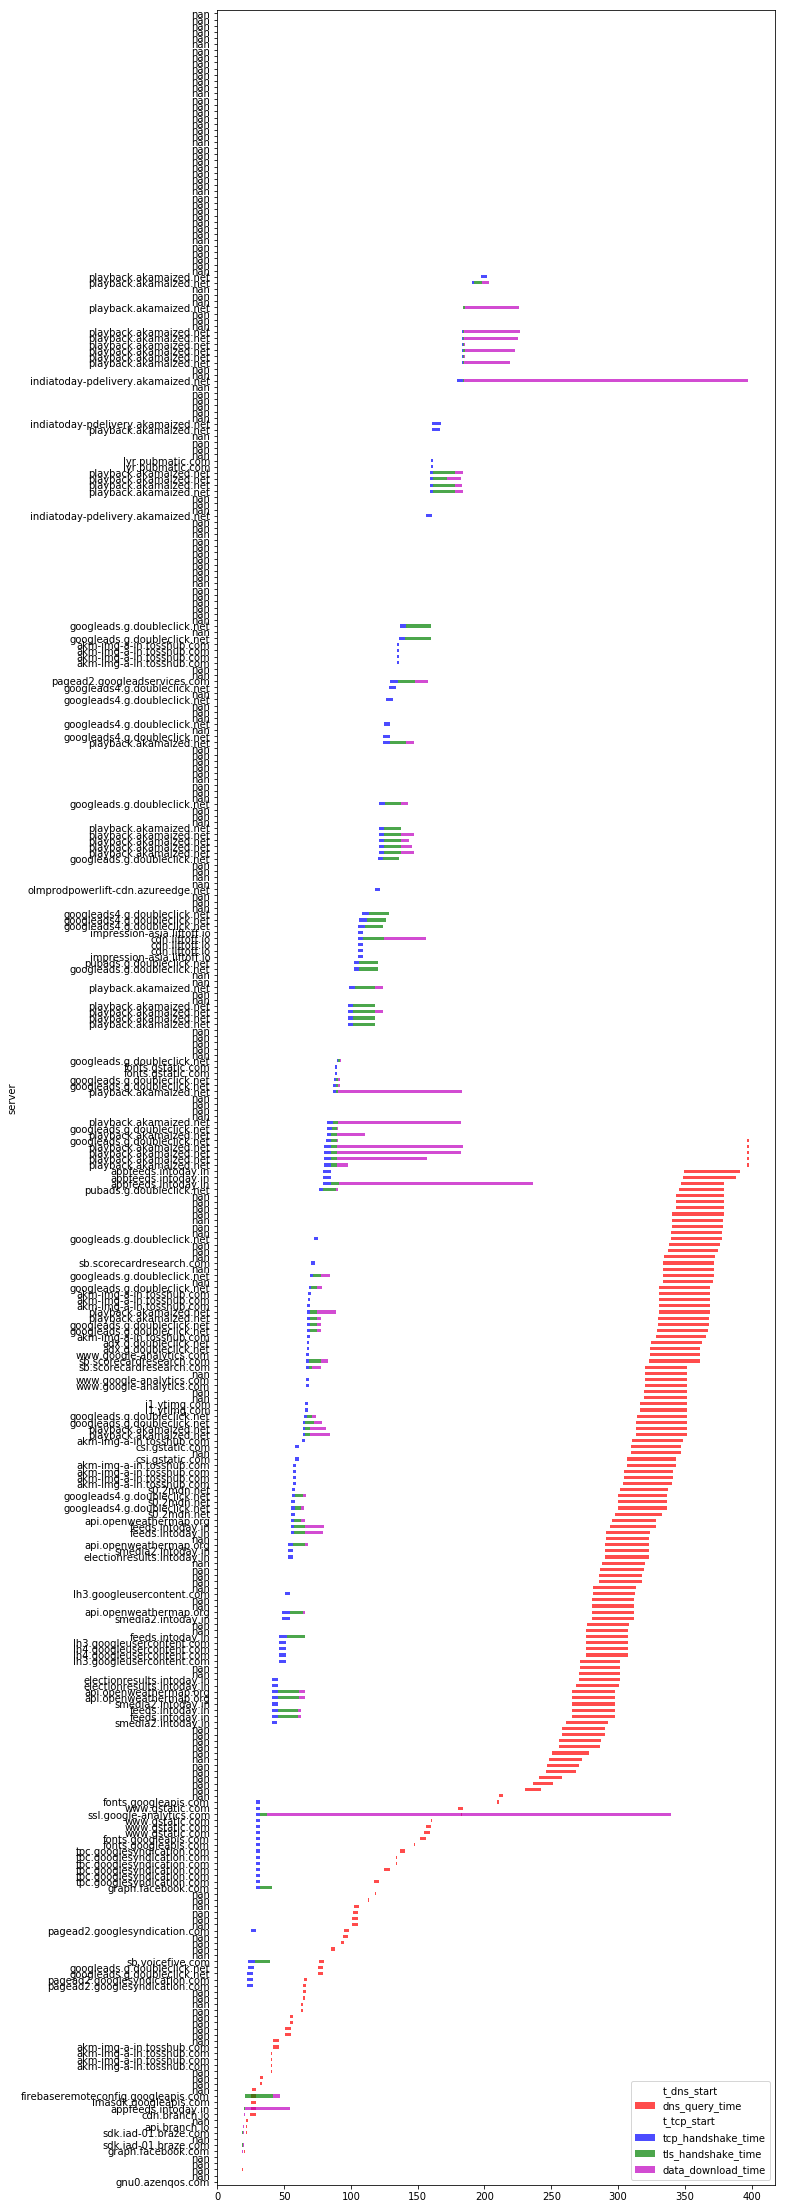

In [347]:
fig, ax = plt.subplots(figsize=(10,40))
ax.grid()


df_dns_time.plot(kind="barh", x="server",
                 y=["t_dns_start", "dns_query_time"],
                 ax=ax, stacked=True, color=["#FFFFFF", "r"], alpha=.7)
df_tcp_time.plot(kind="barh", x="server",
                 y=["t_tcp_start", "tcp_handshake_time", "tls_handshake_time", "data_download_time"],
                ax=ax, stacked=True, color=["#FFFFFF", "b", "g", "m"], alpha=.7)



### Merged Waterfall Data
- Merge dns and tcp data
- There is some time between DNS end and TCP start - take that into account
- Some TCP connections may not have DNS joined with them (since multiple TCP connections from same DNS) so calculate a new time relative for each entry in merged data
- Remove those with no server name before plotting

In [410]:
df_waterfall = pd.merge_asof(df_tcp_time,df_dns_time,
              on='frame.time', by="server",
              tolerance=pd.Timedelta('1000ms')).sort_values(by="frame.time")
df_waterfall["dns_tcp_delta_time"] = df_waterfall["t_tcp_start"] - df_waterfall["t_dns_end"]



# set it to t_dns_start if it exists
df_waterfall["t_start"] = df_waterfall[["t_tcp_start","t_dns_start"]].min(axis=1)

#t_cap_start = df_waterfall.iloc[0]["frame.time"]
#df_waterfall["t_start"] = pd.to_timedelta(df_waterfall["frame.time"] - t_cap_start).dt.total_seconds()

df_waterfall.head(10)

,frame.time,tcp.stream,server,tls_data_proto,t_tcp_start,t_tls_start,tcp_handshake_time,t_data_ttfb,tls_handshake_time,t_data_end,data_download_time,t_dns_end,dns_query_time,t_dns_start,dns_tcp_delta_time,t_start
0,2019-12-23 04:19:18.159096,0.0,gnu0.azenqos.com,http/1.1,0.000000,0.095461,0.095461,0.388571,0.293110,0.668660,0.280089,NaN,NaN,NaN,NaN,0.000000
1,2019-12-23 04:19:19.186082,1.0,NaN,NaN,1.026986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.026986
2,2019-12-23 04:19:19.308089,2.0,NaN,NaN,1.148993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.148993
3,2019-12-23 04:19:27.187272,3.0,NaN,NaN,9.028176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.028176
4,2019-12-23 04:19:28.182212,4.0,NaN,NaN,10.023116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.023116
5,2019-12-23 04:19:36.821129,5.0,graph.facebook.com,http/1.1,18.662033,18.699798,0.037765,18.871480,0.171682,19.412680,0.541200,18.656714,0.049321,18.607393,0.005319,18.607393
6,2019-12-23 04:19:36.908857,6.0,sdk.iad-01.braze.com,http/1.1,18.749761,18.840053,0.090292,19.413315,0.573262,20.101490,0.688175,18.747746,0.039141,18.708605,0.002015,18.708605
7,2019-12-23 04:19:36.976854,7.0,NaN,NaN,18.817758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.817758
8,2019-12-23 04:19:36.987798,8.0,sdk.iad-01.braze.com,http/1.1,18.828702,18.868963,0.040261,19.479811,0.610848,19.786669,0.306858,18.747746,0.039141,18.708605,0.080956,18.708605
9,2019-12-23 04:19:37.323098,9.0,api.branch.io,http/1.1,19.164002,19.414634,0.250632,19.669782,0.255148,20.022688,0.352906,19.161921,0.267539,18.894382,0.002081,18.894382


In [411]:
df_waterfall_filtered = df_waterfall[ df_waterfall["server"].notnull() ]
df_waterfall_filtered

,frame.time,tcp.stream,server,tls_data_proto,t_tcp_start,t_tls_start,tcp_handshake_time,t_data_ttfb,tls_handshake_time,t_data_end,data_download_time,t_dns_end,dns_query_time,t_dns_start,dns_tcp_delta_time,t_start
0,2019-12-23 04:19:18.159096,0.0,gnu0.azenqos.com,http/1.1,0.000000,0.095461,0.095461,0.388571,0.293110,0.668660,0.280089,NaN,NaN,NaN,NaN,0.000000
5,2019-12-23 04:19:36.821129,5.0,graph.facebook.com,http/1.1,18.662033,18.699798,0.037765,18.871480,0.171682,19.412680,0.541200,18.656714,0.049321,18.607393,0.005319,18.607393
6,2019-12-23 04:19:36.908857,6.0,sdk.iad-01.braze.com,http/1.1,18.749761,18.840053,0.090292,19.413315,0.573262,20.101490,0.688175,18.747746,0.039141,18.708605,0.002015,18.708605
8,2019-12-23 04:19:36.987798,8.0,sdk.iad-01.braze.com,http/1.1,18.828702,18.868963,0.040261,19.479811,0.610848,19.786669,0.306858,18.747746,0.039141,18.708605,0.080956,18.708605
9,2019-12-23 04:19:37.323098,9.0,api.branch.io,http/1.1,19.164002,19.414634,0.250632,19.669782,0.255148,20.022688,0.352906,19.161921,0.267539,18.894382,0.002081,18.894382
11,2019-12-23 04:19:38.264030,11.0,cdn.branch.io,http/1.1,20.104934,20.142271,0.037337,20.424084,0.281813,20.574056,0.149972,20.098312,0.039904,20.058408,0.006622,20.058408
12,2019-12-23 04:19:38.374587,12.0,appfeeds.intoday.in,"h2,http/1.1",20.215491,20.324926,0.109435,20.794028,0.469102,54.534188,33.740160,20.213627,0.070952,20.142675,0.001864,20.142675
13,2019-12-23 04:19:38.588243,13.0,imasdk.googleapis.com,"h2,http/1.1",20.429147,20.519487,0.090340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.429147
14,2019-12-23 04:19:38.678298,14.0,firebaseremoteconfig.googleapis.com,http/1.1,20.519202,20.595723,0.076521,41.578696,20.982973,46.884452,5.305756,20.517108,0.114349,20.402759,0.002094,20.402759
19,2019-12-23 04:19:39.473543,19.0,akm-img-a-in.tosshub.com,http/1.1,21.314447,21.783163,0.468716,NaN,NaN,NaN,NaN,21.312884,0.028664,21.284220,0.001563,21.284220


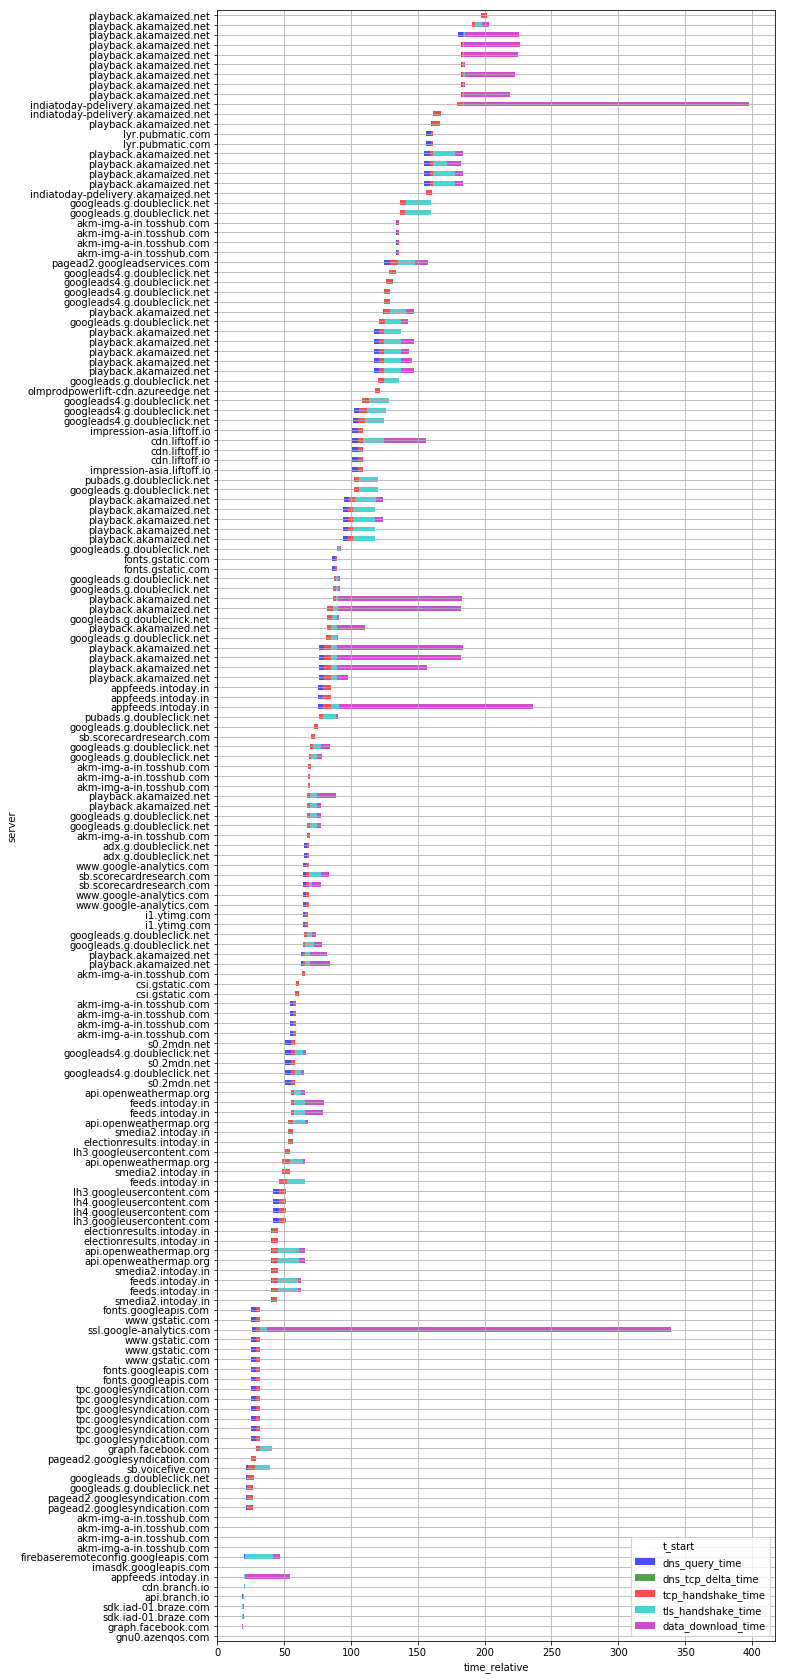

In [414]:
fig, ax = plt.subplots(figsize=(10, 30))
df_waterfall_filtered.plot(kind="barh", x=("server"),
                           y=["t_start", "dns_query_time", "dns_tcp_delta_time", 
                              "tcp_handshake_time", "tls_handshake_time", "data_download_time"],
                           stacked=True, alpha=.7, color=["#FFFFFF", 'b','g','r','c','m'], ax=ax)
ax.set_xlabel("time_relative")
ax.set_ylabel("server")
ax.grid()

In [245]:
df_complete = pd.concat( [df_dns_time, df_tcp_time], ignore_index=True, sort=True )

In [306]:
df_complete.sort_values(by="time_relative").head()

,dns.qry.name,t_data_end,t_data_time,t_data_ttfb,t_dns_end,t_dns_start,t_dns_time,t_tcp_start,t_tls_start,tcp.stream,tcp_handshake_time,time_relative,tls_data_proto,tls_esni,tls_handshake_time
171,NaN,0.66866,0.280089,0.388571,NaN,NaN,NaN,0.000000,0.095461,0.0,0.095461,0.000000,http/1.1,gnu0.azenqos.com,0.29311
172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.026986,NaN,1.0,NaN,1.026986,NaN,NaN,NaN
173,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.148993,NaN,2.0,NaN,1.148993,NaN,NaN,NaN
174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.028176,NaN,3.0,NaN,9.028176,NaN,NaN,NaN
175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.023116,NaN,4.0,NaN,10.023116,NaN,NaN,NaN


#### Try BarH

In [197]:
df = pd.DataFrame({'lab': ['A', 'B', 'C'], 'val1': [10, 30, 20],  'val2': [3, 6, 10]})
df

,lab,val1,val2
0,A,10,3
1,B,30,6
2,C,20,10


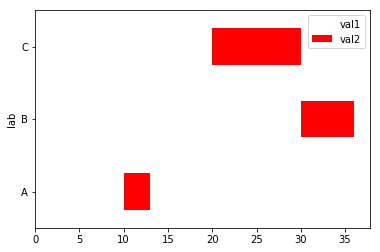

In [203]:
ax = df.plot.barh(x='lab', stacked=True, color=["#FFFFFF", "r"])

### Example

In [130]:
ex1 = list(gp_tcp)[1][1]
ex1

,frame.time_relative,tcp.stream,tcp.srcport,tcp.dstport,tcp.flags,tcp.time_relative,tls.record.content_type,tls.handshake.type,tls.alert_message,tls.handshake.cert_type.type,tls.handshake.extensions_server_name,tls.handshake.extensions_alpn_str,http.response.code,http.request.full_uri,http.request.uri,http.time
21,1.026986,1.0,443.0,44476.0,0x00000011,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,1.067286,1.0,44476.0,443.0,0x00000010,0.040300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4874,60.916895,1.0,44476.0,443.0,0x00000018,59.889909,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4875,60.917705,1.0,44476.0,443.0,0x00000011,59.890719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4898,60.996927,1.0,44476.0,443.0,0x00000011,59.969941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4975,61.237039,1.0,44476.0,443.0,0x00000019,60.210053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5023,61.717092,1.0,44476.0,443.0,0x00000019,60.690106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5119,62.680318,1.0,44476.0,443.0,0x00000019,61.653332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5150,62.854733,1.0,443.0,44476.0,0x00000010,61.827747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5185,63.066648,1.0,443.0,44476.0,0x00000010,62.039662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [119]:
ex1[ex1["tls.handshake.type"]=="1"].iloc[0]["frame.time_relative"]

0.095461

In [89]:
ex2 = df_tcp[df_tcp["tcp.stream"]==11]
ex2.iloc[0]

frame.time_relative                        20.1049
tcp.stream                                      11
tcp.srcport                                  43646
tcp.dstport                                    443
tcp.flags                               0x00000002
tcp.time_relative                                0
tls.record.content_type                        NaN
tls.handshake.type                             NaN
tls.alert_message                              NaN
tls.handshake.cert_type.type                   NaN
tls.handshake.extensions_server_name           NaN
tls.handshake.extensions_alpn_str              NaN
http.response.code                             NaN
http.request.full_uri                          NaN
http.request.uri                               NaN
http.time                                      NaN
Name: 160, dtype: object

In [102]:
ex2

,frame.time_relative,tcp.stream,tcp.srcport,tcp.dstport,tcp.flags,tcp.time_relative,tls.record.content_type,tls.handshake.type,tls.alert_message,tls.handshake.cert_type.type,tls.handshake.extensions_server_name,tls.handshake.extensions_alpn_str,http.response.code,http.request.full_uri,http.request.uri,http.time
160,20.104934,11.0,43646.0,443.0,0x00000002,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
164,20.139684,11.0,443.0,43646.0,0x00000012,0.034750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165,20.139963,11.0,43646.0,443.0,0x00000010,0.035029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
166,20.142271,11.0,43646.0,443.0,0x00000018,0.037337,22,1,NaN,NaN,cdn.branch.io,http/1.1,NaN,NaN,NaN,NaN
168,20.186676,11.0,443.0,43646.0,0x00000010,0.081742,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
171,20.247718,11.0,443.0,43646.0,0x00000010,0.142784,22,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
172,20.247932,11.0,43646.0,443.0,0x00000010,0.142998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
173,20.248034,11.0,443.0,43646.0,0x00000018,0.143100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
174,20.248147,11.0,43646.0,443.0,0x00000010,0.143213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
175,20.322767,11.0,443.0,43646.0,0x00000018,0.217833,22,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### HTTP time

In [42]:
df_tcp[~df_tcp["http.response.code"].isnull()]

,tcp.stream,tcp.srcport,tcp.dstport,tcp.flags,tcp.time_relative,tls.record.content_type,tls.handshake.type,tls.alert_message,tls.handshake.cert_type.type,tls.handshake.extensions_server_name,tls.handshake.extensions_alpn_str,http.response.code,http.request.full_uri,http.request.uri,http.time
1818,47.0,80.0,41768.0,0x00000018,5.051391,NaN,NaN,NaN,NaN,NaN,NaN,200.0,NaN,NaN,2.005225
